In [23]:
# data @ https://finance.yahoo.com/quote/NVDA/history/
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizeres import Adam 
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'tensorflow'

In [12]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime) # Turn dates into datetime objects (not strings)
df.index = df.pop('Date')
df

,Close
Date,
1999-01-22,0.041016
1999-01-25,0.045313
1999-01-26,0.041797
1999-01-27,0.041667
1999-01-28,0.041536
...,...
2024-06-14,131.880005
2024-06-17,130.979996
2024-06-18,135.580002


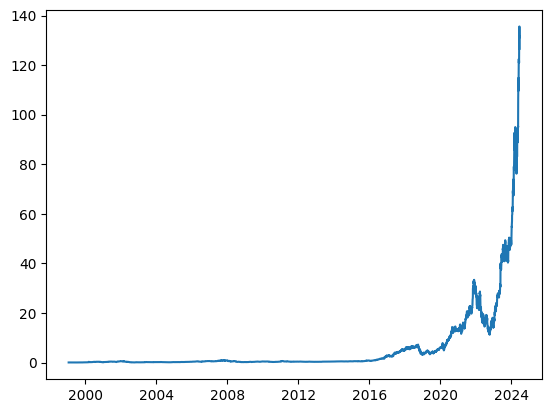

In [14]:
plt.plot(df.index,df['Close'])

In [20]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date 

    dates = [] 
    X, Y = [], [] 

    last_time = False 
    while True: 
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1: 
            print(f'Error: Window size of {n} too large for date {target_date}')
            return 
        values = df_subset['Close'].to_numpy() 
        x,y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x) 
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+dt.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day 
        next_date = dt.datetime(day=int(day), month=int(month), year=int(year))

        if last_time: 
            break 
        target_date = next_date 

        if target_date == last_date: 
            last_time = True 
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates 
    
    X = np.array(X) 
    for i in range(0,n):
        X[:,i]
        ret_df[f'Target-{n-i}'] = X[:,i]

    ret_df['Target'] = Y

    return ret_df 

windowed_df = df_to_windowed_df(df, '1999-01-27', '2024-06-21' )
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1999-01-27,0.041016,0.045313,0.041797,0.041667
1,1999-01-28,0.045313,0.041797,0.041667,0.041536
2,1999-01-29,0.041797,0.041667,0.041536,0.039583
3,1999-02-01,0.041667,0.041536,0.039583,0.040365
4,1999-02-02,0.041536,0.039583,0.040365,0.037240
...,...,...,...,...,...
6387,2024-06-14,120.910004,125.199997,129.610001,131.880005
6388,2024-06-17,125.199997,129.610001,131.880005,130.979996
6389,2024-06-18,129.610001,131.880005,130.979996,135.580002
6390,2024-06-20,131.880005,130.979996,135.580002,130.779999


In [21]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:,0] # extract the dates 

    # extract input matrix
    middle_matrix = df_as_np[:,1:-1]
    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))

    Y = df_as_np[:,-1] # extract output

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((6392,), (6392, 3, 1), (6392,))

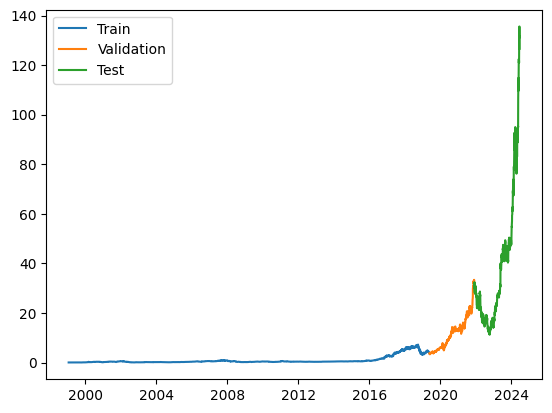

In [22]:
# Train Validation Test Split 
q_80 = int(len(dates)*0.8)
q_90 = int(len(dates)*0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train','Validation','Test'])